# Bedload maps vs DoD maps analysis
---

This notebook contains some analyses to better understand where the observed differences between resulted BAA and morphological changes maps come from. The analyses have been done only on the q05_1 experiment.

In [37]:
import os
import sys
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import importlib

In [17]:
home_dir = os.getcwd()
path_Pi_analysis = os.path.join(home_dir,'..')
path_analysis =  os.path.join(home_dir, 'outputs')
# Add module path needed to import PiQs_BAW_func
PiQs_BAW_func_path = os.path.abspath(os.path.join('..', 'bedload_analysis'))
if PiQs_BAW_func_path not in sys.path:
    sys.path.append(PiQs_BAW_func_path)

# EnvBAA vs DoD maps
---

The following maps are the final results of both bedload and morphological change analyses processing. The bedload activity maps have been produced using an active threshold of *6.5* and a rso threshold of *10 000*.

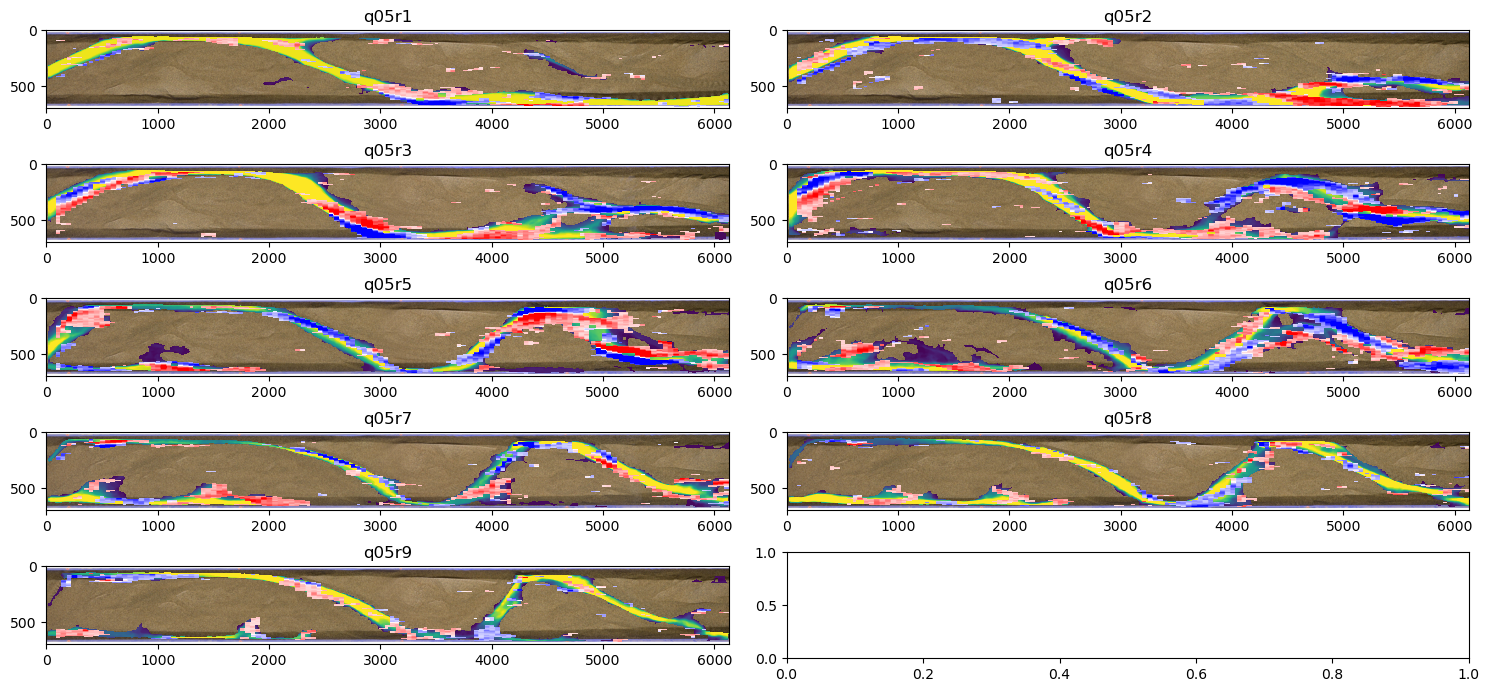

In [14]:
%matplotlib inline
from PIL import Image, ImageOps
path = os.path.join(path_analysis, 'DEM_DoD_envBAA_overlapping','q05_1')
runs = ['q05r1','q05r2','q05r3','q05r4','q05r5','q05r6','q05r7','q05r8','q05r9']
fig, axs = plt.subplots(len(runs)//2+1,2,figsize=(15,7)) # creating my fig
for i,run in enumerate(runs):
    path_image = os.path.join(path_Pi_analysis,'bedload_analysis','input_data','1_Fused_images',run[0:3],run)
    # Use divmod to get row and column from index
    row, col = divmod(i, 2)
    filename = f'{run[0:3]}_1_{run}_DEM_DoD_envBAA_DoS_stack'
    filename_image = f'Img0081.jpg'
    # Import DoD and envBAA
    stack = np.load(os.path.join(path, filename+'.npy'))
    DoD = stack[1,:,:]
    DoD = np.where(DoD==0, np.nan, DoD)
    DoD = np.repeat(DoD, 5, axis=1)
    DoD = np.repeat(DoD, 5, axis=0)
    
    envBAA = stack[2,:,:]
    envBAA = np.where(envBAA==0,np.nan,envBAA)
    envBAA = np.repeat(envBAA, 5, axis=1)
    envBAA = np.repeat(envBAA, 5, axis=0)

    # Import Fused image
    image = Image.open(os.path.join(path_image,filename_image))
    # Create the padding 
    padding = (0, 20, 0, 20)  # (left, top, right, bottom)
    image = ImageOps.expand(image, border=padding, fill=(255, 255, 255))  # White padding
    
    axs[row,col].imshow(image, aspect=1)
    axs[row,col].imshow(envBAA,cmap = 'viridis',vmin=0, vmax=80, aspect=1)
    axs[row,col].imshow(DoD,cmap = 'bwr',vmin=-10, vmax=10, aspect=1)
    axs[row,col].set_title(run)
plt.tight_layout()
plt.show() 

We can observe on these maps that there are several morphological changes in areas where no bedload activity has been detected. Severeal reasons may explain this:  
1. These areas have been filtered out during the time-lapse imaging processing due to the value of the thresholds used or the timespan betwwen two succesive images used to compute the difference of saturation intensity.
2. The DoD processing tends to keep artificial morphological changes
3. There are morphological changes happenning after the photographic survey during the relaxing time after stopping the water flow.

The following analyses investigate the two first possibilities. But first the next section presents the sensitivity of the morphological active width to this difference of detection between bedload and morphological analyses.

# Effect of 'suspicious' morphological changes on the morphological active width (MAW)
---

## Bedload activity intensity where there are suspicious morphological changes

On the following plot, the 'suspicious' morphological changes (objects) are highlighted in red. These objects are then selected to plot the difference of saturation intensity distribution at the location of these objects.

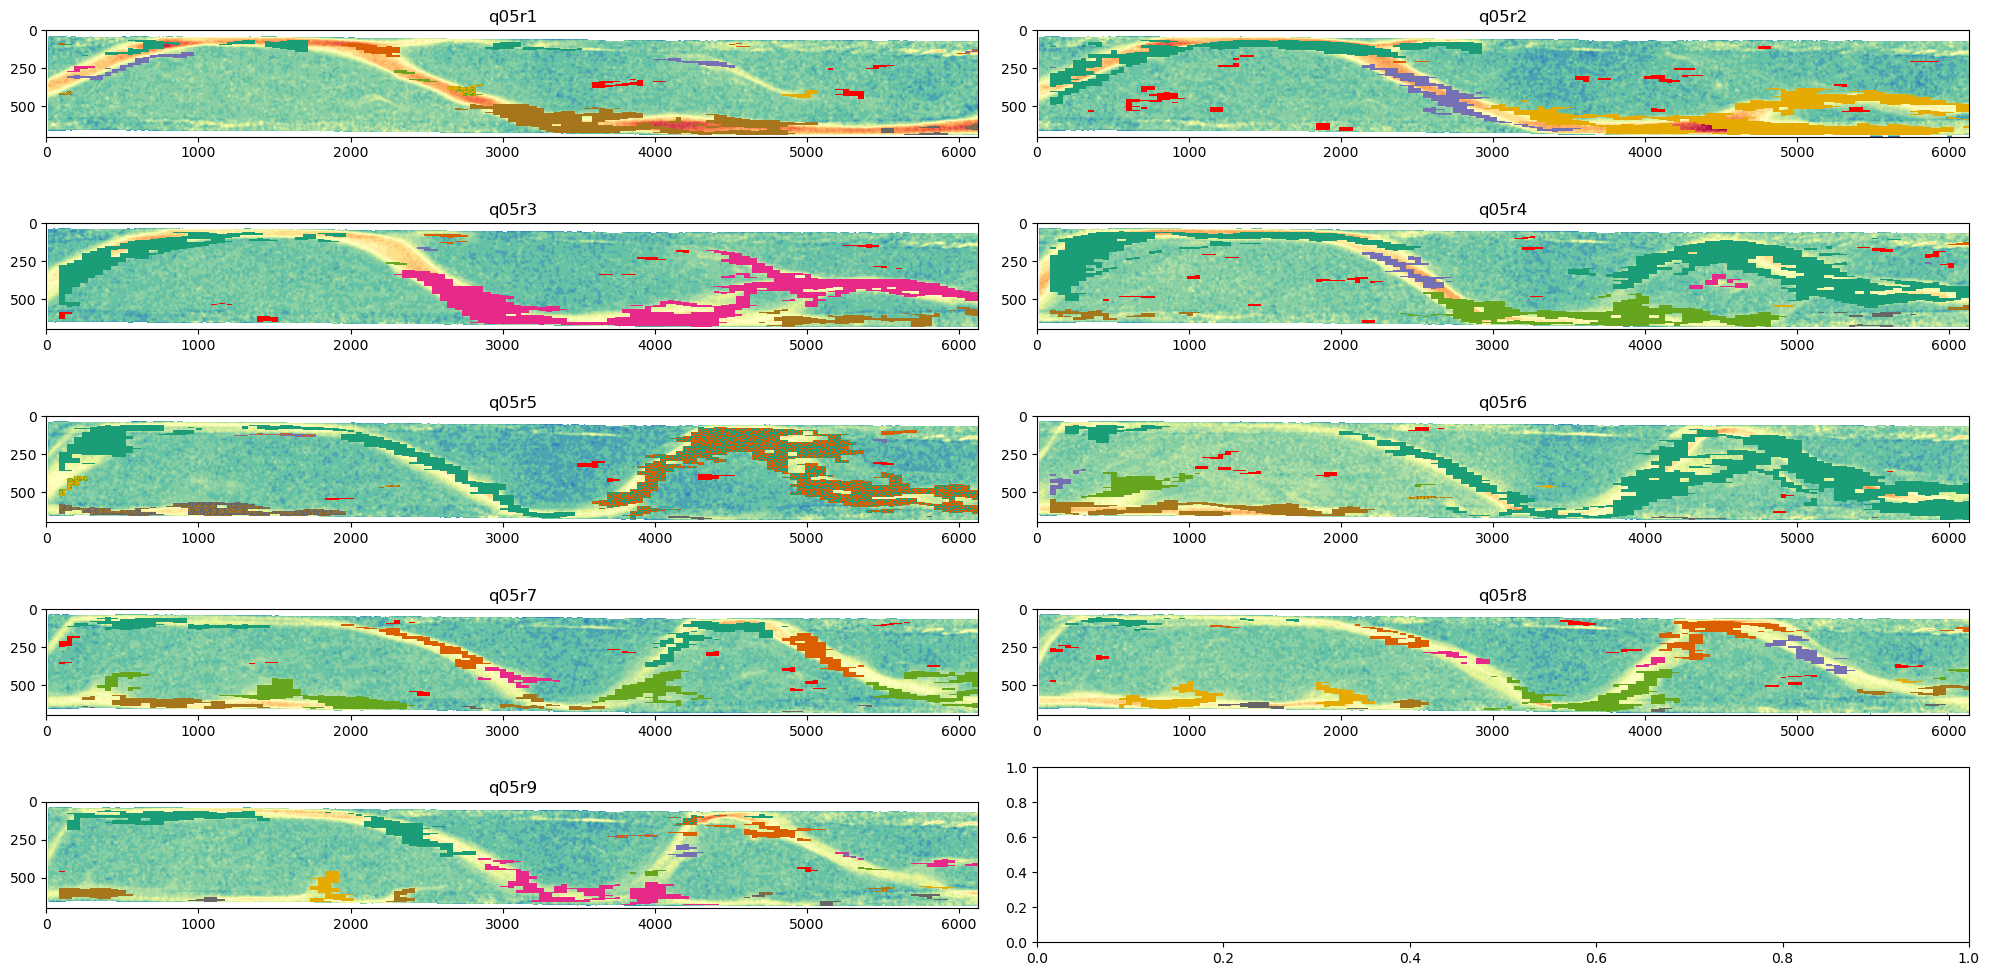

In [96]:
%matplotlib inline
path = os.path.join(path_analysis,'DEM_DoD_envBAA_overlapping','q05_1')
runs = ['q05r1','q05r2','q05r3','q05r4','q05r5','q05r6','q05r7','q05r8','q05r9']
selected_labels_dict = {
    'q05r1': [17, 15, 10, 12], 
    'q05r2': [20, 16, 25, 26,12,13,21, 8, 5, 14, 22, 11,4, 7, 15], 
    'q05r3': [16, 13, 12, 9, 7, 11, 5, 15], 
    'q05r4': [14, 18, 20, 10, 15, 27, 6, 19, 12, 8, 7, 2],
    'q05r5': [7, 12, 12, 14, 9, 8, 7],
    'q05r6': [4, 6, 10, 2, 9, 15, 19],
    'q05r7': [2, 7, 11, 10, 22, 8, 9, 14, 20, 2, 4, 12,21],
    'q05r8': [12, 15, 24, 5, 13, 27, 20, 17],
    'q05r9': [16, 13]
}
fig, axs = plt.subplots(len(runs)//2+1,2,figsize=(20,10)) # creating my fig
labeled_DoD_dict = {}
envDoS_maps = {}
for i,run in enumerate(runs):
    label_list = []
    path_image = os.path.join(path_Pi_analysis,'bedload_analysis','input_data','1_Fused_images',run[0:3],run)
    # Use divmod to get row and column from index
    row, col = divmod(i, 2)
    filename = f'{run[0:3]}_1_{run}_DEM_DoD_envBAA_DoS_stack'
    stack= np.load(os.path.join(path, filename+'.npy'))
    DoD = stack[1,:,:]
    DoD = np.where(DoD==0, np.nan, DoD)
    DoD = np.repeat(DoD, 5, axis=1)
    DoD = np.repeat(DoD, 5, axis=0)

    # labeling processing
    # Step 1: Create a mask to ignore NaN values
    mask = np.isnan(DoD)

    # Step 2: Replace NaN values with 0 or any value (not affecting the labels)
    DoD_cleaned = np.where(mask, 0, DoD)

    # Step 3: Label connected regions of non-zero elements
    # We treat non-zero values as the same "object" and set a threshold for connection.
    # Structure defines connectivity (here 4-connectivity)
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity, use np.array([[0,1,0], [1,1,1], [0,1,0]]) for 4-connectivity

    labeled_DoD, num_features = ndimage.label(DoD_cleaned != 0, structure=structure)

    # Step 4: Calculate the size of each labeled region
    sizes = ndimage.sum(DoD_cleaned != 0, labeled_DoD, range(1, num_features + 1))
    
    envBAA = stack[2,:,:]
    envBAA = np.where(envBAA==0,np.nan,envBAA)
    envBAA = np.repeat(envBAA, 5, axis=1)
    envBAA = np.repeat(envBAA, 5, axis=0)
    
    envDoS = stack[-1,:,:]
    envDoS = np.where(envDoS==0,np.nan,envDoS)
    envDoS = np.repeat(envDoS, 5, axis=1)
    envDoS = np.repeat(envDoS, 5, axis=0)

    labeled_DoD_dict[run] = labeled_DoD
    envDoS_maps[run] = envDoS

    labeled_DoD = np.where(labeled_DoD==0, np.nan, labeled_DoD)

    # highlight selected suspicious objects
    selected_labels = selected_labels_dict[run]
    filtered_labeled_DoD_arr = np.where(np.isin(labeled_DoD, selected_labels), labeled_DoD, np.nan)
    
    #axs[row,col].imshow(envBAA,cmap = 'viridis',vmin=0, vmax=80, aspect=1)
    axs[row,col].imshow(envDoS,cmap = 'Spectral_r', vmin=0, vmax=20, aspect=1)#, alpha=0.5)
    #axs[row,col].imshow(DoD,cmap = 'bwr',vmin=-10, vmax=10, aspect=1)
    axs[row,col].imshow(labeled_DoD,cmap = 'Dark2',  aspect=1)
    axs[row,col].imshow(filtered_labeled_DoD_arr,cmap = 'bwr_r', vmin=1, vmax=1, aspect=1)
    
    axs[row,col].set_title(run)
plt.tight_layout()
plt.show() 

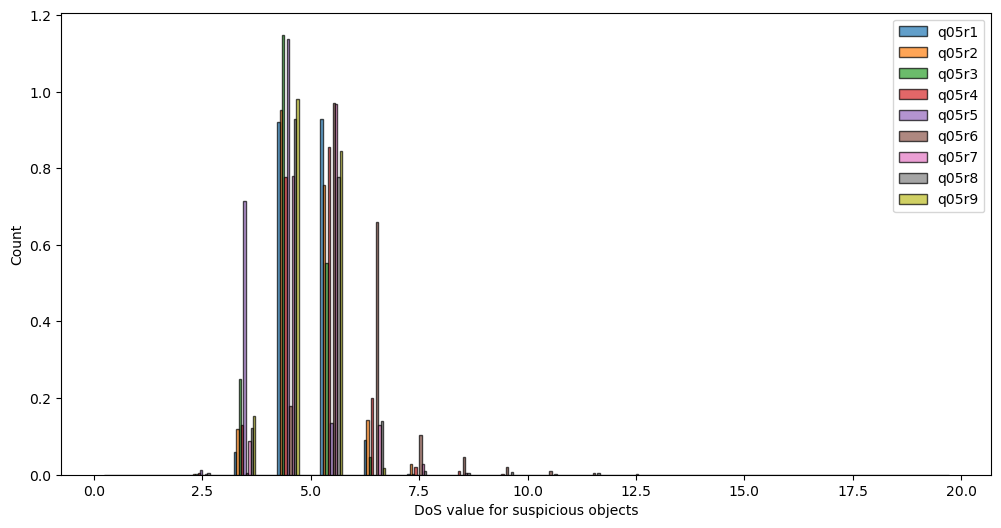

In [85]:
%matplotlib inline
# Create the figure and axis
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Define your runs and selected labels dictionary
runs = ['q05r1', 'q05r2', 'q05r3', 'q05r4', 'q05r5', 'q05r6', 'q05r7', 'q05r8', 'q05r9']
selected_labels_dict = {
    'q05r1': [17, 15, 10, 12], 
    'q05r2': [20, 16, 25, 26,12,13,21, 8, 5, 14, 22, 11,4, 7, 15], 
    'q05r3': [16, 13, 12, 9, 7, 11, 5, 15], 
    'q05r4': [14, 18, 20, 10, 15, 27, 6, 19, 12, 8, 7, 2],
    'q05r5': [7, 12, 12, 14, 9, 8, 7],
    'q05r6': [4, 6, 10, 2, 9, 15, 19],
    'q05r7': [2, 7, 11, 10, 22, 8, 9, 14, 20, 2, 4, 12,21],
    'q05r8': [12, 15, 24, 5, 13, 27, 20, 17],
    'q05r9': [16, 13]
}
# Define bins
bins = np.arange(0, 20, 0.5)  # Bins for histogram
bin_width = 0.5  # Width of each bin

# Offset for each bar in the group
bar_width = bin_width / len(runs)  # Make bars narrower to fit side by side

# Loop through each run
for i, run in enumerate(runs):
    # Get labeled_DoD and filter it based on the selected labels
    labeled_DoD = labeled_DoD_dict[run]
    selected_labels = selected_labels_dict[run]
    filtered_labeled_DoD_arr = np.where(np.isin(labeled_DoD, selected_labels), labeled_DoD, np.nan)
    
    # Get the environmental DoS and mask it
    envDoS = envDoS_maps[run]
    envDoS = np.where(filtered_labeled_DoD_arr > 0, envDoS, 0)

    # Compute histogram using numpy
    hist, bin_edges = np.histogram(envDoS[envDoS > 0].flatten(), bins=bins, density=True)

    # Plot side-by-side bars with an offset for each run
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Get bin centers
    axs.bar(bin_centers + i * bar_width, hist, width=bar_width, edgecolor='black', alpha=0.7, label=run)

# Add legend, labels, and show the plot
axs.legend(loc='upper right')
axs.set_xlabel('DoS value for suspicious objects')
axs.set_ylabel('Count')

plt.show()

Most of the pixels are below the active threshold of 6.5 used to produce the BAA maps.

## Area (%) of the suspicious morphological changes and missed ones

Here, the impact of these 'suspicious' morphological changes on the MAW is addressed. The total area of the suspicious objects is first computed and compare with the total area of morphological changes. Then, the MAW is computed with and without the suspicious objects.

In [94]:
path = os.path.join(path_analysis,'DEM_DoD_envBAA_overlapping','q05_1')
runs = ['q05r1','q05r2','q05r3','q05r4','q05r5','q05r6','q05r7','q05r8','q05r9']
filtered_labeled_DoD = {}
labeled_DoD_dict = {}
envDoS_maps = {}

# Define your runs and selected labels dictionary
runs = ['q05r1', 'q05r2', 'q05r3', 'q05r4', 'q05r5', 'q05r6', 'q05r7', 'q05r8', 'q05r9']
selected_labels_dict = {
    'q05r1': [17, 15, 10, 12], 
    'q05r2': [20, 16, 25, 26,12,13,21, 8, 5, 14, 22, 11,4, 7, 15], 
    'q05r3': [16, 13, 12, 9, 7, 11, 5, 15], 
    'q05r4': [14, 18, 20, 10, 15, 27, 6, 19, 12, 8, 7, 2],
    'q05r5': [7, 12, 12, 14, 9, 8, 7],
    'q05r6': [4, 6, 10, 2, 9, 15, 19],
    'q05r7': [2, 7, 11, 10, 22, 8, 9, 14, 20, 2, 4, 12,21],
    'q05r8': [12, 15, 24, 5, 13, 27, 20, 17],
    'q05r9': [16, 13]
}

for i,run in enumerate(runs):
    label_list = []
    path_image = os.path.join(path_Pi_analysis,'bedload_analysis','input_data','1_Fused_images',run[0:3],run)
    # Use divmod to get row and column from index
    row, col = divmod(i, 2)
    filename = f'{run[0:3]}_1_{run}_DEM_DoD_envBAA_DoS_stack'
    stack= np.load(os.path.join(path, filename+'.npy'))
    DoD = stack[1,:,:]
    DoD = np.where(DoD==0, np.nan, DoD)

    # labeling processing
    # Step 1: Create a mask to ignore NaN values
    mask = np.isnan(DoD)

    # Step 2: Replace NaN values with 0 or any value (not affecting the labels)
    DoD_cleaned = np.where(mask, 0, DoD)

    # Step 3: Label connected regions of non-zero elements
    # We treat non-zero values as the same "object" and set a threshold for connection.
    # Structure defines connectivity (here 4-connectivity)
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity, use np.array([[0,1,0], [1,1,1], [0,1,0]]) for 4-connectivity

    labeled_DoD, num_features = ndimage.label(DoD_cleaned != 0, structure=structure)

    valid_labels = selected_labels_dict[run]

    # Step 4: Filter the labeled array by keeping only valid labels
    filtered_labeled_DoD_arr = np.where(np.isin(labeled_DoD, valid_labels), labeled_DoD, np.nan)

    # Step 5: Compute the total area of each suspicious objects
    total_objects_area = len(filtered_labeled_DoD_arr[filtered_labeled_DoD_arr>0])

    total_MC_area = len(DoD[np.abs(DoD)>0])

    MAW = np.round(total_MC_area/120/np.shape(DoD)[1] *100, decimals=2)

    DoD_without_sus_object = np.where(np.isin(labeled_DoD, valid_labels), np.nan, labeled_DoD)
    total_area_without_objects = len(DoD_without_sus_object[DoD_without_sus_object>0])
    MAW_without_objects = np.round(total_area_without_objects/120/np.shape(DoD)[1] *100, decimals=2)
    MAW_diff = np.round(MAW - MAW_without_objects, decimals=1)
    Object_area_proportion = np.round(total_objects_area/total_MC_area*100, decimals=2)

    print(run)
    print('The area proportion of suspicious morphological changes compared to total MC is: ' + str(Object_area_proportion) + ' %')
    #print('The morphological active width is: ' + str(MAW) + ' %')
    #print('The morphological active width without suspicious objects is: ' + str(MAW_without_objects ) + ' %')
    print('The difference in the MAW with or without suspicious objects is: ' + str(MAW_diff) + ' %')

q05r1
The area proportion of suspicious morphological changes compared to total MC is: 7.86 %
The difference in the MAW with or without suspicious objects is: 1.1 %
q05r2
The area proportion of suspicious morphological changes compared to total MC is: 12.23 %
The difference in the MAW with or without suspicious objects is: 3.2 %
q05r3
The area proportion of suspicious morphological changes compared to total MC is: 4.92 %
The difference in the MAW with or without suspicious objects is: 1.2 %
q05r4
The area proportion of suspicious morphological changes compared to total MC is: 5.46 %
The difference in the MAW with or without suspicious objects is: 1.8 %
q05r5
The area proportion of suspicious morphological changes compared to total MC is: 2.92 %
The difference in the MAW with or without suspicious objects is: 0.8 %
q05r6
The area proportion of suspicious morphological changes compared to total MC is: 4.06 %
The difference in the MAW with or without suspicious objects is: 1.2 %
q05r7
The

The impact of the 'suspicious' areas on the MAW is very low. That is why, we decided that changing the data processing is not worthy. Mainly for two reasons: 
1. Highlighting long term bedload activity by increasing the timespan between two successive images also add noise.
2. Changing the DoD processing to better capture real morphological changes does not reduce the presence of small areas of morphological changes. (see the 'Comparison between v7 and v8 processing' section)
3. This difference between bedload and morphological analyses is only for q05 runs.  

The following analyses support this decision.

# EnvBAA timespan analysis
---

This analysis investigates the effect of changing the timespan between two successive images in detecting bedload activity. The aim is to know if it is possible to add information on the bedload activity to the original envelop. Here, we consider timespans of 1 min, 4 min, 20 min (1/4 of the total time), 40 min (1/2 of the total time), and 80 min (total time: i.e. difference between first and last image). The following plots show (for each row):  
1. Envelop of the mean difference of saturation map
2. The envBAA map applying the thresholds directly from 1.
3. The envBAA map resulting from the sum of all the BAA maps of the run.

In [18]:
# Apply 1_PiQs_BAW_map_generator as a function
import cv2
from PiQs_BAW_func_v1 import *
def PiQs_BAW_map_generator(image, run, path_input_data, thrs_actDS, thrs_actUS, thrs_act, shad_coeff, thrs_rso1, thrs_rso2):
   
    #image = np.where(image<=thrs,0,image)
    dim_y, dim_x = image.shape

    # Load UPSTREAM-DOVNSTREAM MASK
    maskUD_path = os.path.join(os.path.join(path_input_data, '1_Fused_images',run[0:3], run), 'Mask.tif') # Define image path
    maskUD = Image.open(maskUD_path) # Open image as image
    maskUD_arr = np.array(maskUD)
    maskUD_arr = np.where(maskUD_arr==255, 1, 0)
    maskUD_arr = maskUD_arr[:dim_y,:dim_x]
    
    # TODO
    # 3. THRESHOLDING
        
    # APPLY THRESHOLD UPSTREAM
    th, diff_arr_thrsUS = cv2.threshold(image, thrs_actUS, 255, cv2.THRESH_TOZERO)
    diff_arr_thrsUS = diff_arr_thrsUS*maskUD_arr
        
    # APPLY THRESHOLD DOWNSTREAM
    th, diff_arr_thrsDS = cv2.threshold(image, thrs_actDS, 255, cv2.THRESH_TOZERO)
    diff_arr_thrsDS = diff_arr_thrsDS*abs(maskUD_arr-1)
        
    #MERGE THE TWO IMAGES
    diff_arr_thrs = diff_arr_thrsUS + diff_arr_thrsDS
    diff_arr_blur = diff_arr_thrs
        
    # 4. MORPHOLOGICAL ANALYSIS
    # 4.a FILL SMALL HOLES
    diff_arr_rm_hls, diff_arr_rm_hls_target = fill_small_holes(
            matrix=diff_arr_blur, avg_target_kernel=51, area_threshold=1000,
            connectivity=1, value=10)
        
    # ERODE AREAS TO FIND PENINSULA
    diff_arr_rm_hls = diff_arr_rm_hls*(ndimage.binary_erosion(diff_arr_rm_hls, iterations=2))
        
    # 4.d REMOVE SMALL OBJECTS
    diff_arr_rsm_mask = morphology.remove_small_objects(diff_arr_rm_hls>0, min_size=thrs_rso1, connectivity=1)
    diff_arr_rsm = diff_arr_rm_hls*diff_arr_rsm_mask
        
    # AVERAGE
    n_row0, n_col0 =21,51  # 7,7 is fine
    kernel0=np.ones((n_row0,n_col0), np.float32)/(n_row0*n_col0)
    diff_arr_avg1 = cv2.filter2D(src=diff_arr_rsm,ddepth=-1, kernel=kernel0)
        
    # REAPPLY THRESHOLD
    # APPLY THRESHOLD UPSTREAM
    th, diff_arr_thrs2US = cv2.threshold(diff_arr_avg1, thrs_actUS, 255, cv2.THRESH_TOZERO)
    diff_arr_thrs2US = diff_arr_thrs2US*maskUD_arr
        
    # APPLY THRESHOLD DOWNSTREAM
    th, diff_arr_thrs2DS = cv2.threshold(diff_arr_avg1, thrs_actDS, 255, cv2.THRESH_TOZERO)
    diff_arr_thrs2DS = diff_arr_thrs2DS*abs(maskUD_arr-1)
        
    #MERGE THE TWO IMAGES
    diff_arr_avg1 = diff_arr_thrs2US + diff_arr_thrs2DS
        
    diff_arr_avg1_mask = morphology.remove_small_objects(diff_arr_avg1>0, min_size=thrs_rso2, connectivity=1)
    diff_arr_avg1 = diff_arr_avg1*diff_arr_avg1_mask
        
    # PERFORM LINEAR DOWNSAMPLING TO OBTAIN THE LOW RESOLUTION VERSION
    BAA_map_LR5 = non_overlapping_average(diff_arr_avg1, kernel_size=5) 
    maskUD_arr_LR5 = non_overlapping_average(maskUD_arr, kernel_size=5)
    maskUD_arr_LR5 = np.where(maskUD_arr_LR5>0.5,1,0)
    
    # TODO
    # REAPPLY THRESHOLD 
    # APPLY THRESHOLD UPSTREAM
    th, BAA_map_LR5_US = cv2.threshold(BAA_map_LR5, thrs_actUS, 255, cv2.THRESH_TOZERO)
    BAA_map_LR5_US = BAA_map_LR5_US*maskUD_arr_LR5
        
    # APPLY THRESHOLD DOWNSTREAM
    th, BAA_map_LR5_DS = cv2.threshold(BAA_map_LR5, thrs_actDS, 255, cv2.THRESH_TOZERO)
    BAA_map_LR5_DS = BAA_map_LR5_DS*abs(maskUD_arr_LR5-1)
        
    #MERGE THE TWO IMAGES
    BAA_map_LR5 = BAA_map_LR5_US + BAA_map_LR5_DS

    return BAA_map_LR5
    

## Run 1

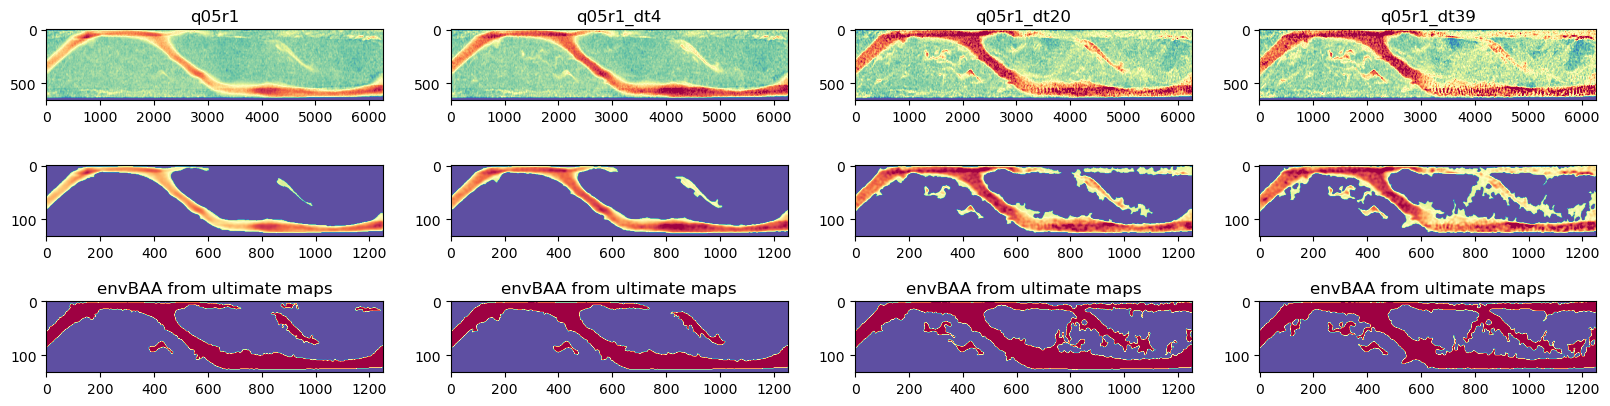

In [26]:
%matplotlib inline
runs = ['q05r1','q05r1_dt4','q05r1_dt20','q05r1_dt39']
path_input_data = os.path.join(path_Pi_analysis, 'bedload_analysis','input_data')
thrs_actDS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.5
thrs_actUS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.4
thrs_act = thrs_actDS
shad_coeff = 2.0
thrs_rso1 = 10000
thrs_rso2 = 10000
fig, axs = plt.subplots(3,len(runs),figsize=(20,5)) # creating my fig

for i,run in enumerate(runs):
    filename = f'{run}_DoS_mean_map'
    envfilename = f'{run}_BAA_mean_envmap_from_ultimates'
    image = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', filename+'.npy'))
    envBAA_ultimates = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', envfilename +'.npy'))
    envBAA_ultimates = np.where(envBAA_ultimates>0,20,0)
    BAA_map_LR5 = PiQs_BAW_map_generator(image, run, path_input_data, thrs_actDS, thrs_actUS, thrs_act, shad_coeff, thrs_rso1, thrs_rso2)   
    axs[0,i].imshow(image,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[1,i].imshow(BAA_map_LR5,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[2,i].imshow(envBAA_ultimates,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[0,i].set_title(run)
    axs[2,i].set_title('envBAA from ultimate maps')
plt.show() 

## Run 2

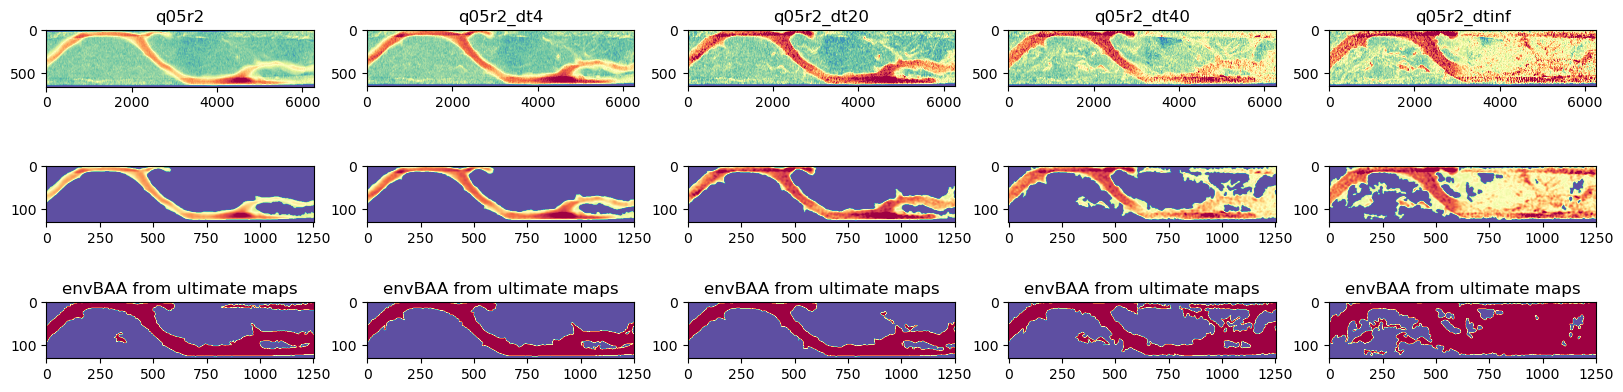

In [31]:
%matplotlib inline
runs = ['q05r2','q05r2_dt4','q05r2_dt20','q05r2_dt40','q05r2_dtinf']
path_input_data = os.path.join(path_Pi_analysis, 'bedload_analysis','input_data')
thrs_actDS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.5
thrs_actUS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.4
thrs_act = thrs_actDS
shad_coeff = 2.0
thrs_rso1 = 10000
thrs_rso2 = 10000
fig, axs = plt.subplots(3,len(runs),figsize=(20,5)) # creating my fig

for i,run in enumerate(runs):
    filename = f'{run}_DoS_mean_map'
    envfilename = f'{run}_BAA_mean_envmap_from_ultimates'
    image = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', filename+'.npy'))
    envBAA_ultimates = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', envfilename +'.npy'))
    envBAA_ultimates = np.where(envBAA_ultimates>0,20,0)
    BAA_map_LR5 = PiQs_BAW_map_generator(image, run, path_input_data, thrs_actDS, thrs_actUS, thrs_act, shad_coeff, thrs_rso1, thrs_rso2)   
    axs[0,i].imshow(image,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[1,i].imshow(BAA_map_LR5,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[2,i].imshow(envBAA_ultimates,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[0,i].set_title(run)
    axs[2,i].set_title('envBAA from ultimate maps')
plt.show() 

## Run 4

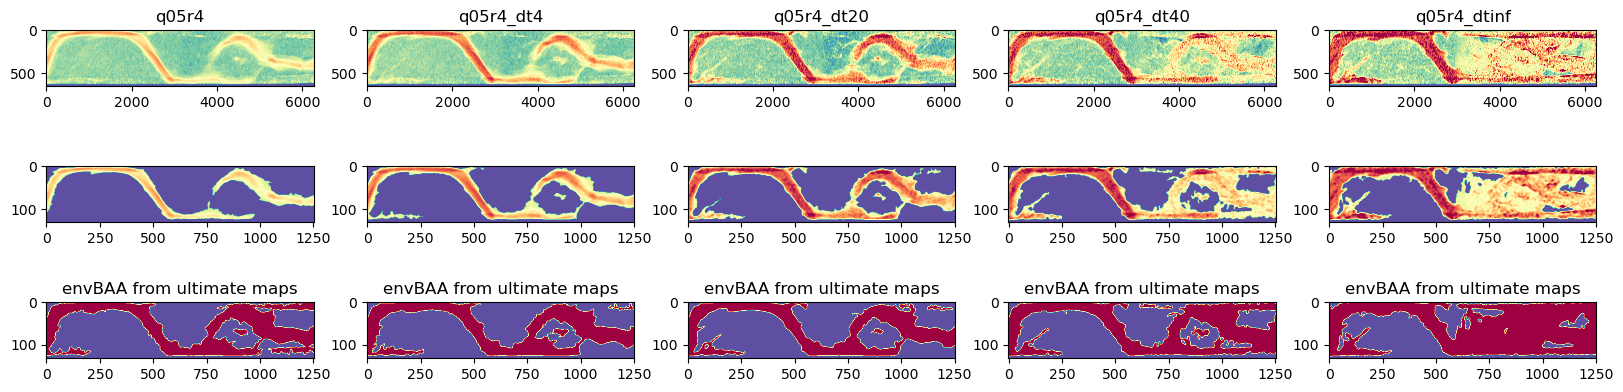

In [33]:
%matplotlib inline
runs = ['q05r4','q05r4_dt4','q05r4_dt20','q05r4_dt40','q05r4_dtinf']
path_input_data = os.path.join(path_Pi_analysis, 'bedload_analysis','input_data')
thrs_actDS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.5
thrs_actUS = 6.5 # Active threshold - For values equal or grater than thrs_act bedeload is considered as active # 6.4
thrs_act = thrs_actDS
shad_coeff = 2.0
thrs_rso1 = 10000
thrs_rso2 = 10000
fig, axs = plt.subplots(3,len(runs),figsize=(20,5)) # creating my fig

for i,run in enumerate(runs):
    filename = f'{run}_DoS_mean_map'
    envfilename = f'{run}_BAA_mean_envmap_from_ultimates'
    image = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', filename+'.npy'))
    envBAA_ultimates = np.load(os.path.join(path_Pi_analysis,'bedload_analysis','outputs','3_Image_filtering_BAW_map','DoS_maps',run,'envelop', envfilename +'.npy'))
    envBAA_ultimates = np.where(envBAA_ultimates>0,20,0)
    BAA_map_LR5 = PiQs_BAW_map_generator(image, run, path_input_data, thrs_actDS, thrs_actUS, thrs_act, shad_coeff, thrs_rso1, thrs_rso2)   
    axs[0,i].imshow(image,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[1,i].imshow(BAA_map_LR5,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[2,i].imshow(envBAA_ultimates,cmap = 'Spectral_r',vmin=0, vmax=20, aspect=2)
    axs[0,i].set_title(run)
    axs[2,i].set_title('envBAA from ultimate maps')
plt.show() 

# DoD processing analysis
---

In [35]:
# functions
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the first band
    return array

## Raw DoDs

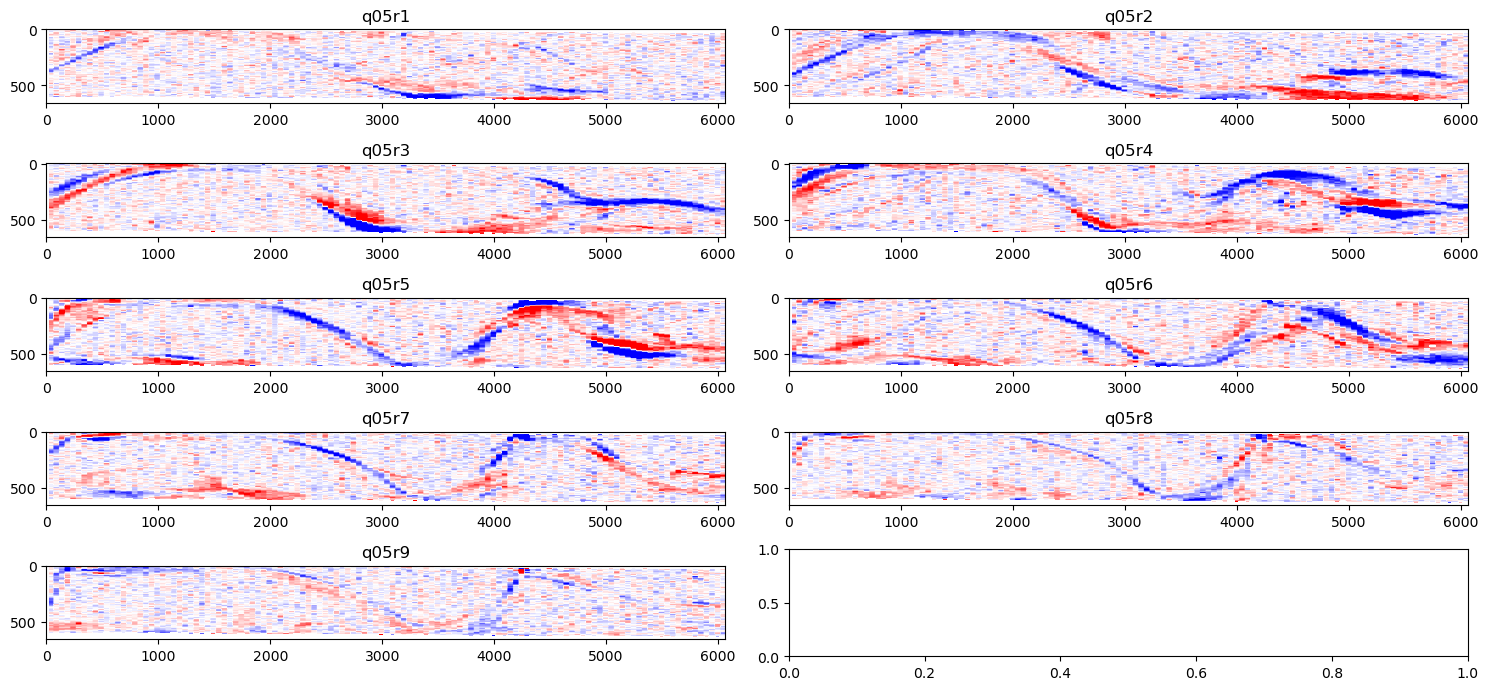

In [40]:
%matplotlib inline
path = os.path.join(path_analysis,'surveys_images_overlapping_test')
runs = ['q05r1','q05r2','q05r3','q05r4','q05r5','q05r6','q05r7','q05r8','q05r9']#[]#
fig, axs = plt.subplots(len(runs)//2+1,2,figsize=(15,7)) # creating my fig
for i,run in enumerate(runs):
    # Use divmod to get row and column from index
    row, col = divmod(i, 2)
    filename = f'{run}_raw_DoD_resized_image_raster'

    DoD = read_tif(os.path.join(path, filename+'.tiff'))
    DoD = np.where(DoD==-9999, np.nan, DoD)
    axs[row,col].imshow(DoD,cmap = 'bwr',vmin=-10, vmax=10, aspect=1)
    axs[row,col].set_title(run)

plt.tight_layout()
plt.show() 

## Comparison between v7 and v8 filtering process 

In the version 8 of the 1_DoD_filt script, the modifications are the following:  
*In this v8 version, 6th step (RE-PERFORM ISOLATED PIXEL REMOVAL) has been modified. Instead of performing the remove_small_object function considering both erosion and deposition areas, it is applied on erosion and deposition areas separately. Then, the 2 arrays are merged together to continue the processing as past versions. Also, the connectivity parameter for the second application of the remove_small_object function has been set to 2 to consider the diagonal connectivity of pixels.*

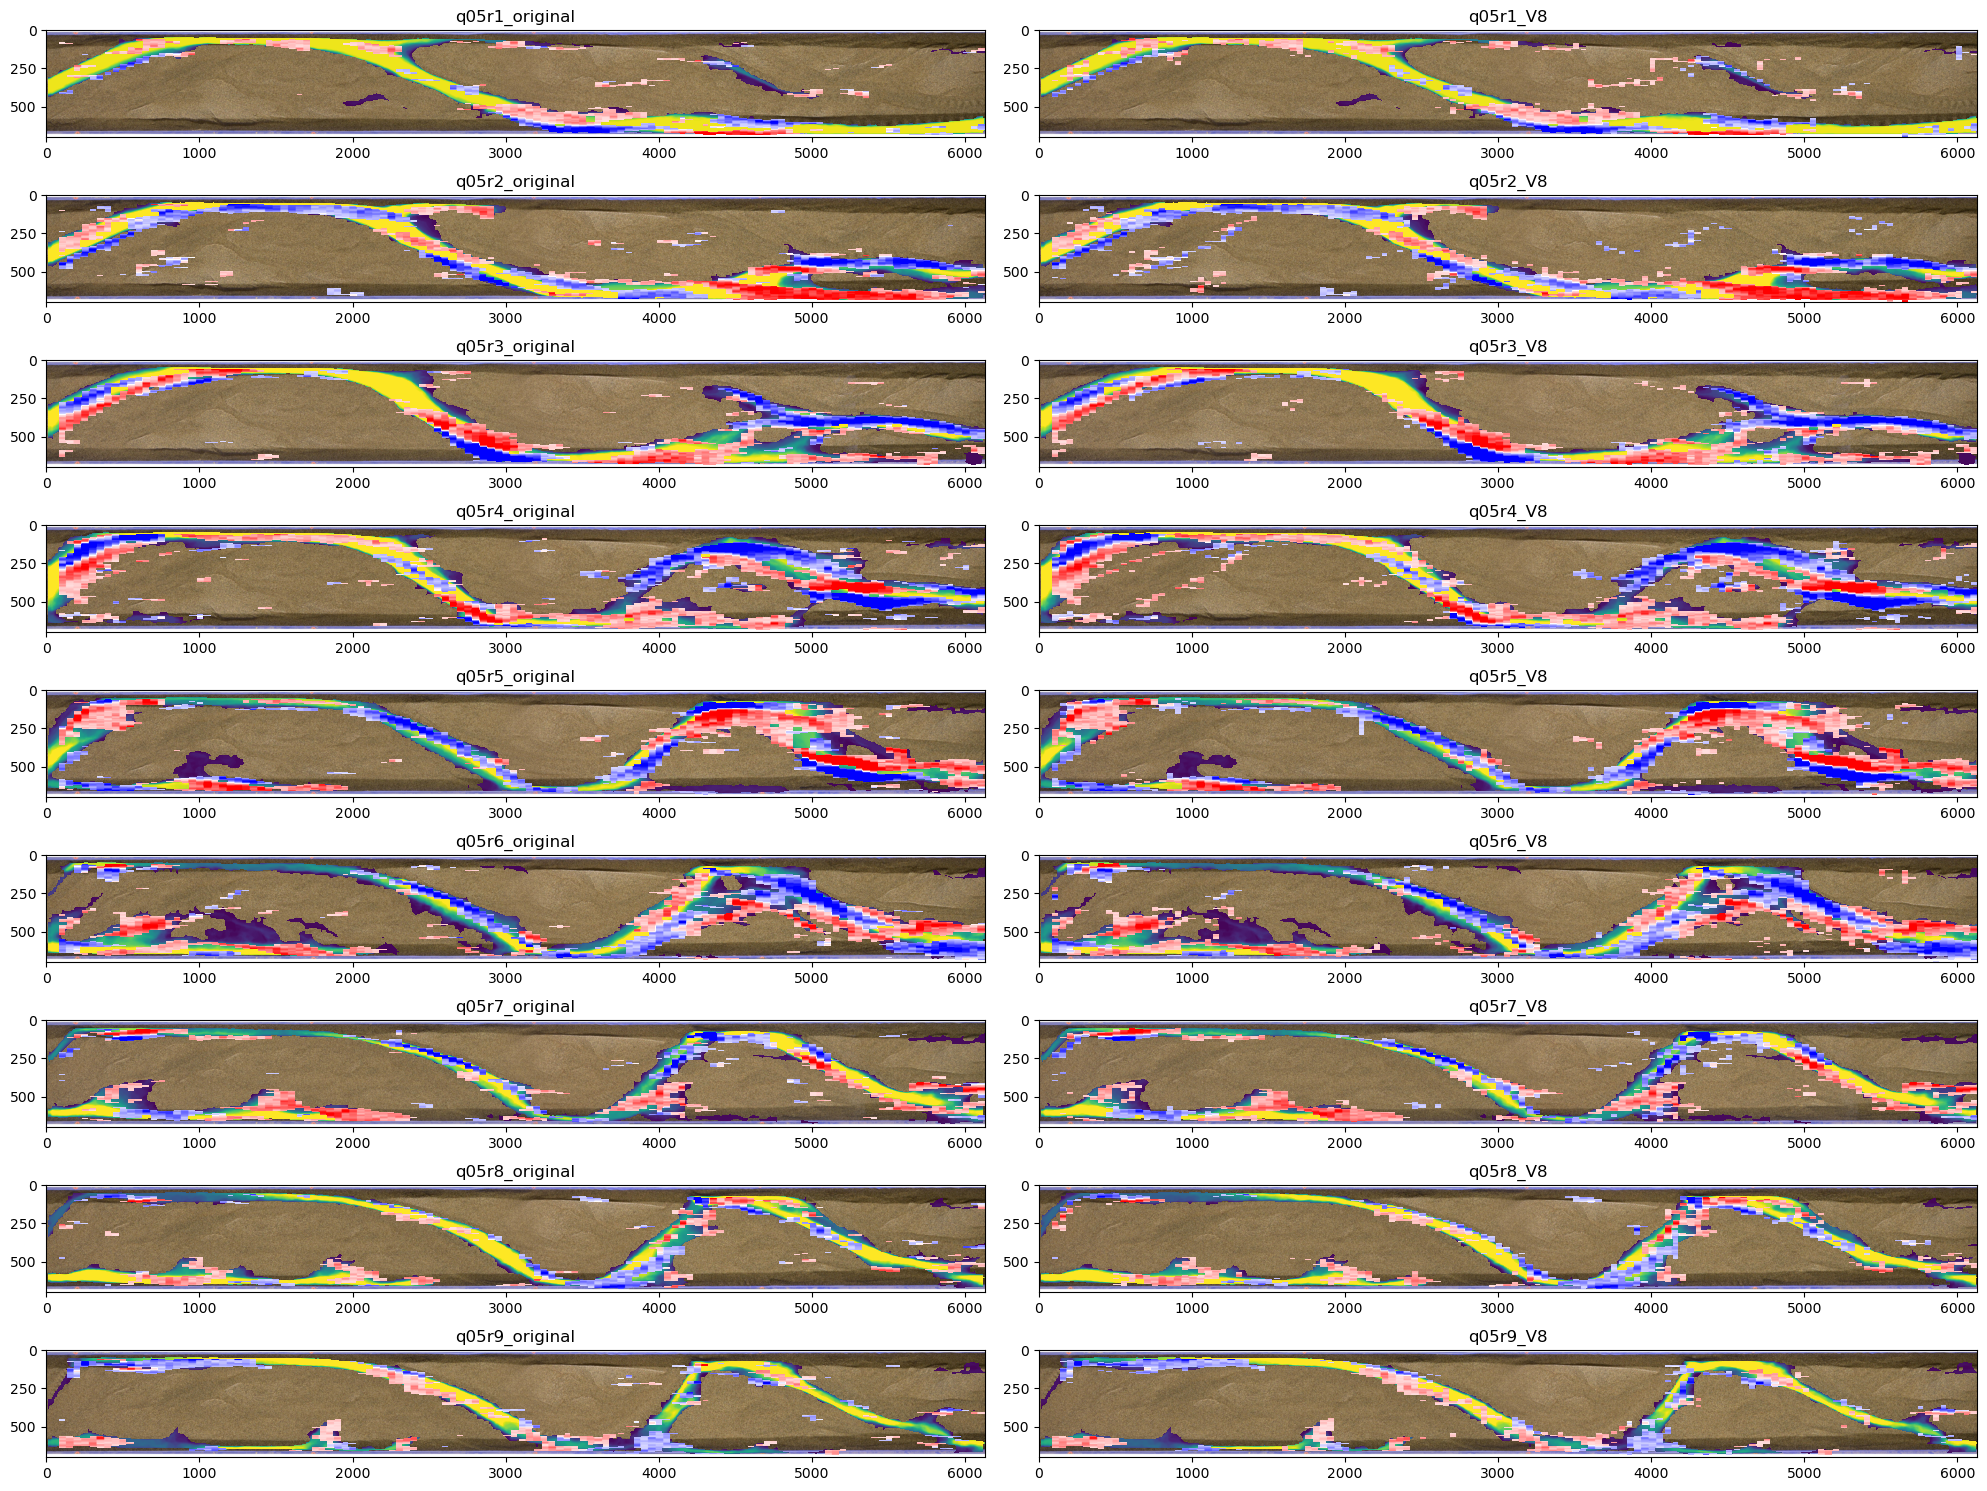

In [41]:
%matplotlib inline
from PIL import Image, ImageOps
path1 = os.path.join(path_analysis,'DEM_DoD_envBAA_overlapping','q05_1_original')
path2 = os.path.join(path_analysis,'DEM_DoD_envBAA_overlapping','q05_1_DoD_filt_v8')
runs = ['q05r1','q05r2','q05r3','q05r4','q05r5','q05r6','q05r7','q05r8','q05r9']
fig, axs = plt.subplots(len(runs),2,figsize=(20,15)) # creating my fig
for i,run in enumerate(runs):
    path_image = os.path.join(path_Pi_analysis,'bedload_analysis','input_data','1_Fused_images',run[0:3],run)
    # Use divmod to get row and column from index
    row, col = divmod(i, 2)
    filename = f'{run[0:3]}_1_{run}_DEM_DoD_envBAA_stack'
    filename_image = f'Img0081.jpg'
    stack_or= np.load(os.path.join(path1, filename+'.npy'))
    stack_new= np.load(os.path.join(path2, filename+'.npy'))
    DoD = stack_or[1,:,:]
    DoD = np.where(DoD==0, np.nan, DoD)
    DoD = np.repeat(DoD, 5, axis=1)
    DoD = np.repeat(DoD, 5, axis=0)
    envBAA = stack_or[2,:,:]
    envBAA = np.where(envBAA==0,np.nan,envBAA)
    envBAA = np.repeat(envBAA, 5, axis=1)
    envBAA = np.repeat(envBAA, 5, axis=0)

    DoD_new = stack_new[1,:,:]
    DoD_new = np.where(DoD_new==0, np.nan, DoD_new)
    DoD_new = np.repeat(DoD_new, 5, axis=1)
    DoD_new = np.repeat(DoD_new, 5, axis=0)
    envBAA_new = stack_new[2,:,:]
    envBAA_new = np.where(envBAA_new==0,np.nan,envBAA_new)
    envBAA_new = np.repeat(envBAA_new, 5, axis=1)
    envBAA_new = np.repeat(envBAA_new, 5, axis=0)
    
    image = Image.open(os.path.join(path_image,filename_image))
    # Create the padding 
    padding = (0, 20, 0, 20)  # (left, top, right, bottom)
    image = ImageOps.expand(image, border=padding, fill=(255, 255, 255))  # White padding
    axs[i,0].imshow(image, aspect=1)
    axs[i,0].imshow(envBAA,cmap = 'viridis',vmin=0, vmax=80, aspect=1)
    axs[i,0].imshow(DoD,cmap = 'bwr',vmin=-10, vmax=10, aspect=1)
    axs[i,0].set_title(run +'_original')

    axs[i,1].imshow(image, aspect=1)
    axs[i,1].imshow(envBAA_new,cmap = 'viridis',vmin=0, vmax=80, aspect=1)
    axs[i,1].imshow(DoD_new,cmap = 'bwr',vmin=-10, vmax=10, aspect=1)
    axs[i,1].set_title(run +'_V8')
plt.tight_layout()
plt.show() 